## RDD figure 1

Imports

In [84]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect, causaleffect_linear

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [10]:
#Load simulations and compute different average cost functions
N = 19
nsims = 1
c = 0.75
T = 500000
deltaT = 50

fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']

#Pretty slowly firing...
i = 3;
j = 3;
h1 = hs[i,j,0,0,0:T]
v1 = vs[i,j,0,0,0:T]
h2 = hs[i,j,0,1,0:T]
v2 = vs[i,j,0,1,0:T]

tau_s = 0.2
t_filter = np.linspace(0, 2, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]
s1 = np.convolve(h1, exp_filter)[0:len(h1)]
s2 = np.convolve(h2, exp_filter)[0:len(h1)]

In [11]:
x=3
alpha1 = 80
alpha2 = -40
mu = 1

v1 = vs[i,j,0,0,0:T]
v2 = vs[i,j,0,1,0:T]

#Compute a cost function
cost_s = (alpha1*s1+alpha2*s2-x**2)**2

#Block voltage output and cost function
cost_s_r = cost_s.reshape((-1, deltaT))
v1_r = v1.reshape((-1, deltaT))
v2_r = v2.reshape((-1, deltaT))

#Take max voltage in each block, take cost at end of block
v1 = np.max(v1_r, 1)
v2 = np.max(v2_r, 1)
cost_s = np.squeeze(cost_s_r[:,-1])

#Compute the causal effect
p = 0.05
abv = (v1>mu) & (v1<(mu+p))
blo = (v1<mu) & (v1>(mu-p))
C_abv = cost_s[abv]
C_blo = cost_s[blo]
mu_1_blo = np.mean(C_blo)
mu_1_abv = np.mean(C_abv)

abv = (v2>mu) & (v2<(mu+p))
blo = (v2<mu) & (v2>(mu-p))
C_abv = cost_s[abv]
C_blo = cost_s[blo]
mu_2_blo = np.mean(C_blo)
mu_2_abv = np.mean(C_abv)

beta_1 = mu_1_abv-mu_1_blo
beta_2 = mu_2_abv-mu_2_blo

In [12]:
#Compute some regression lines
#lr = KernelRidge(kernel = 'rbf', gamma=1e-6, alpha=1e-2)
lr = linear_model.LinearRegression()

x0ltMu = v1[v1<mu]
lr.fit(x0ltMu.reshape(-1,1), cost_s[v1<mu].reshape(-1,1)) 
x0ltMu.sort()
y0ltMu = lr.predict(x0ltMu.reshape(-1,1))
y0lt_thr = lr.predict(1)

x1ltMu = v2[v2<mu]
lr.fit(x1ltMu.reshape(-1,1), cost_s[v2<mu].reshape(-1,1)) 
x1ltMu.sort()
y1ltMu = lr.predict(x1ltMu.reshape(-1,1))
y1lt_thr = lr.predict(1)

x0gtMu = v1[v1>mu]
lr.fit(x0gtMu.reshape(-1,1), cost_s[v1>mu].reshape(-1,1)) 
x0gtMu.sort()
y0gtMu = lr.predict(x0gtMu.reshape(-1,1))
y0gt_thr = lr.predict(1)

x1gtMu = v2[v2>mu]
lr.fit(x1gtMu.reshape(-1,1), cost_s[v2>mu].reshape(-1,1)) 
x1gtMu.sort()
y1gtMu = lr.predict(x1gtMu.reshape(-1,1))
y1gt_thr = lr.predict(1)

Make the plot

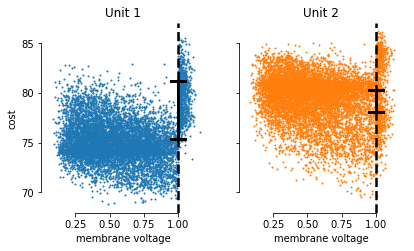

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(6.5,3.5))
ax1.plot(v1, 77.5+(77.5-cost_s), '.C0', markersize=2);
ax2.plot(v2, cost_s, '.C1', markersize=2);
ax1.set_title("Unit 1")
ax2.set_title("Unit 2")
ax1.set_xlabel("membrane voltage")
ax2.set_xlabel("membrane voltage")
ax1.set_ylabel("cost")

sns.despine(trim = True)

tkx = np.array([0.95, 1.05])

ax1.axvline(x=1, linestyle='--', color=(0,0,0), linewidth = 2.5)
ax2.axvline(x=1, linestyle='--', color=(0,0,0), linewidth = 2.5)

ax1.plot(tkx, mu_1_blo*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax1.plot(tkx, mu_1_abv*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax1.plot([1, 1], [mu_1_abv, mu_1_blo], color=(0,0,0), linewidth=3)
ax2.plot(tkx, mu_2_blo*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax2.plot(tkx, mu_2_abv*np.ones(tkx.shape), color=(0,0,0), linewidth=3)
ax2.plot([1, 1], [mu_2_abv, mu_2_blo], color=(0,0,0), linewidth=3);

#ax1.plot(x0ltMu,y0ltMu,'C0',x0gtMu,y0gtMu, color=(0,0,0), linewidth=3);
#ax2.plot(x1ltMu,y1ltMu,'C1',x1gtMu,y1gtMu, color=(0,0,0), linewidth=3);

ax1.set_xlim([0, 1.2])
ax2.set_xlim([0, 1.2])
ax1.set_yticks(np.array([70, 75, 80, 85]))
#ax2.yaxis.set_visible(False)

plt.savefig('./fig_1a.pdf')
plt.savefig('./fig_1a.png')

Also make the probability of firing graph.

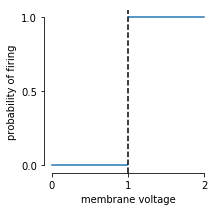

In [46]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
N = 100
x = np.linspace(0,2,N)
y = np.hstack((np.zeros(N/2), np.ones(N/2)))
ax.plot(x[0:50], y[0:50], 'C0', x[50:100], y[50:100], 'C0')
ax.set_xlabel('membrane voltage')
sns.despine(trim=True)
ax.set_ylabel('probability of firing')
ax.axvline(x=1, linestyle='--', color=(0,0,0))
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0, 1, 2])
plt.savefig('./fig_1b.pdf')

Make counter factual diagrams.

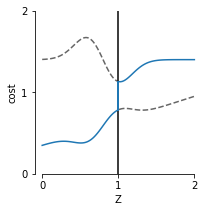

In [50]:
fig,ax = plt.subplots(1,1,figsize=(3,3))

y1 = np.exp(-10*(x-.8)**2)*(x-.8)+0.65+.3*x-.3
y2 = -2*np.exp(-10*(x-.8)**2)*(x-.8)+1.4
ax.plot(x[0:50],y1[0:50], 'C0')
ax.plot(x[0:50],y2[0:50], '--', color=(0.4,0.4,0.4))
ax.plot(x[50:100],y1[50:100], '--', color=(0.4,0.4,0.4))
ax.plot(x[50:100],y2[50:100], 'C0')
ax.set_xlabel('Z')
ax.set_ylabel('cost')
ax.axvline(x=1, color=(0,0,0))
ax.set_ylim([0, 2])
ax.plot([1, 1], [y1[50], y2[50]], 'C0', linewidth=2);
sns.despine(trim=True)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])
plt.savefig('./fig_1c.pdf')

In [110]:
sigma = 10
mu = 1
tau = 1
params = ParamsLIF(sigma = sigma, mu = mu, tau = tau)
t = 50
np.random.seed(4102)
lif = LIF(params, t = t)

In [111]:
lif.W[0] = 10
lif.params.c = 0.9
(v, h, _, _) = lif.simulate()
#Mean rate here is 7Hz. Suggests we take a DeltaT of 70ms

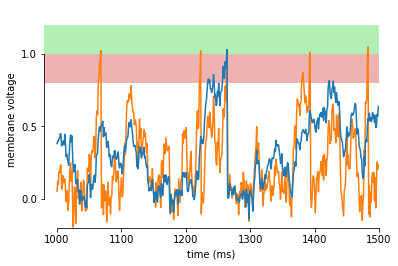

In [114]:
tmin = 1000
tmax = tmin+500
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(range(tmin, tmax), v[0,tmin:tmax], 'C1')
ax.plot(range(tmin, tmax), v[1,tmin:tmax], 'C0')

p1 = patches.Rectangle((980, 1), 1000, .2, alpha=0.3, facecolor=(0, 0.8, 0))
p2 = patches.Rectangle((980, 0.8), 1000, .2, alpha=0.3, facecolor=(0.8, 0, 0))

ax.add_patch(p1)
ax.add_patch(p2)

ax.set_xlim([980, tmax])
ax.set_ylim([-0.2, 1.3])

ax.set_yticks([0, 0.5, 1])
sns.despine(trim=True)

ax.set_xlabel('time (ms)')
ax.set_ylabel('membrane voltage')
plt.savefig('./fig_1d.pdf')

In [106]:
#Possible seeds: 4102